# Download data from NORA3 and save to ncfile

The following codes is a guide to download data from the NWP NORA3 at a chosen time period and save it as an nc-file. Data available at https://thredds.met.no/thredds/catalog/nora3_subset_atmos/wind_hourly/catalog.html. This script use the subset atmosphere files containing wind_speed and wind_direction at heights above surface (10m, 20m, 50m, 100m, 250m, 500m, 750m). choose a datespan (years, months) and save it as an ncfile.

- wind speed
- wind direction

Data available from: 1985.01 to (current month minus 6-7 months time lag), check link for latest date

Model run 4 times a day, every 6h, the files contains hourly updated data based on these runs



In [1]:
# Importing necessary modules

import xarray as xr
import numpy as np

import netCDF4 as nc
import matplotlib.pylab as plt
import pandas as pd

import pyproj
import datetime as dt
from datetime import date, timedelta

import requests
from __future__ import print_function
from IPython.display import display, HTML

In [1]:

def get_coordinates_center_OWS(location_name):
    locations = {
        'Nordavind_A': {
            'latitude': 71.1314956,
            'longitude': 32.048109
        },
        'Nordavind_B': {
            'latitude': 71.7880587,
            'longitude': 27.7221338
        },
        'Nordavind_C': {
            'latitude': 71.7471898,
            'longitude': 19.9808019
        },
        'Nordavind_D': {
            'latitude': 71.473272,
            'longitude': 18.7614613
        },
        'Utsira_nord': {
            'latitude': 59.2740869,
            'longitude': 4.5441279
        },
        'Sørlige_nordsjø_2': {
            'latitude': 59.7894747,
            'longitude': 4.9314619
        }
    }

    if location_name in locations:
        coordinates = locations[location_name]
        return coordinates['latitude'], coordinates['longitude']
    else:
        return None



## Seklima station information retrival with frost api 

[Link to frost webpage](https://frost.met.no/index.html)

1. Create client id for yourself 
    * [Create client id here](https://frost.met.no/auth/requestCredentials.html)
    
This is used to retrive the longitude and latitude

In [2]:
# Insert your own client ID here
client_id = 'insert client ID'

In [3]:
'''
Getting the data for the meta dataframe

Using the frost api for seklima
'''

endpoint = 'https://frost.met.no/sources/v0.jsonld'

# Dictionary with elements to retrieve
parameters = {
    'fields': 'name,id,geometry,masl,validFrom'
}

# Issue an HTTP GET request
r = requests.get(endpoint, parameters, auth=(client_id,''))
# Extract JSON data
json = r.json()

# Check if the request worked, print out any errors
if r.status_code == 200:
    data_exp = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


In [4]:
'''
Transforming the data from a raw json format retrieved by requests 
to a pandas df format

When redefining the query the new columns need to be spesified for the dataframe df
'''

meta_df = pd.DataFrame(columns=['id', 'name', 'lon', 'lat', 'heigh-asl (m)','operating period (from)'])
ignored_values = 0
for i in range(len(data_exp)):
    row = []
    try:
        row.append(data_exp[i]['id'])
        row.append(data_exp[i]['name'])
        row.append(data_exp[i]['geometry']['coordinates'][0])
        row.append(data_exp[i]['geometry']['coordinates'][1])
        row.append(data_exp[i]['masl'])
        row.append(data_exp[i]['validFrom'])
        meta_df.loc[len(meta_df)] = row
    except:
        ignored_values += 1
        continue


print(f'Number of discarded values {ignored_values}')

# Setting the station id as row index2
meta_df = meta_df.set_index('id')

display(meta_df)

Number of discarded values 88


,name,lon,lat,heigh-asl (m),operating period (from)
id,,,,,
SN47230,ÅKRA UNGDOMSSKOLE,5.196300,59.255500,18,2013-10-29T00:00:00.000Z
SN23670,E16 RYFOSS,8.817500,61.137500,406,2018-01-23T00:00:00.000Z
SN59450,STADLANDET,5.211500,62.146700,75,1923-01-01T00:00:00.000Z
SN12590,E6 MJØSBRUA,10.672500,60.928000,128,2011-01-01T00:00:00.000Z
SN26640,E134 DARBU,9.777300,59.702500,155,2016-04-19T00:00:00.000Z
...,...,...,...,...,...
SN74780,NAMSVATN II,13.540300,64.960800,460,2019-09-01T00:00:00.000Z
SN1292500,NAGYKANIZSA,16.970556,46.456111,139,1979-05-20T00:00:00.000Z
SN1712400,ESKISEHIR HAVALIMANI,30.579700,39.781000,786,1978-05-31T00:00:00.000Z


- Change station ID to match measurement station to get station coordinates
    * [stations](https://seklima.met.no/stations/)
 
or 

- Insert site_name to get coordinates from center of OWS

In [5]:

#################


station_id = "SN76956" # insert station ID, ex: 'SN76956' Goliat ,  'SN20926' hjelmsøybanken  ,   SN76926 Sleipner


################

longitude = meta_df.loc[f"{station_id}"]["lon"]
latitude = meta_df.loc[f"{station_id}"]["lat"]

print(f"{station_id}: longitude = {longitude}, latitude = {latitude}")

SN76956: longitude = 22.25, latitude = 71.3112


- Change the site name to one of the locations in get_coordinates 

In [3]:
# insert the OWS name you want the data extracted from

################

site_name = 'Nordavind_A'

################

latitude, longitude = get_coordinates_center_OWS(site_name) # gets the latitude and longitude of the chosen site

In [ ]:
# Choose latitude, longitude

latitude = 
longitude = 

## Projecting coordinates
Starts by projecting the chosen Latitude and Longitude coordinate to x and y cooridnates used in the model

- No changes needed in this part

In [6]:
"""
load in a random file from the NORA3 dataset, this is just used to project latitude/longitude to the correspinding 
x- and y-coordinate 
"""
          
filename = "https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/wind_hourly/arome3kmwind_1hr_202212.nc"
ncfile   = nc.Dataset(filename)



#######
# Projection
crs_NORA = pyproj.CRS.from_cf(
         {
            "grid_mapping_name": "lambert_conformal_conic",
            "standard_parallel": [66.3, 66.3],
            "longitude_of_central_meridian": -42.0,
            "latitude_of_projection_origin": 66.3,
             "earth_radius": 6371000.0,
         }
)

# Transformer to project from ESPG:4368 (WGS:84) to our lambert_conformal_conic
proj = pyproj.Transformer.from_crs(4326,crs_NORA,always_xy=True)
# Compute projected coordinates of lat/lon point
# Coordinates for OWS chosen earlyer
lat = latitude #N
lon = longitude #E
X,Y = proj.transform(lon,lat)

# Find nearest neighbour
x = ncfile.variables["x"][:]
y = ncfile.variables["y"][:]

Ix = np.argmin(np.abs(x - X)) # Nearest neighbour to LON 
Iy = np.argmin(np.abs(y - Y)) # Nearest neighbour to LAT 

ncfile.close()

In [ ]:
# to check for all available variables run the code below

filename = "https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/wind_hourly/arome3kmwind_1hr_202212.nc"
ncfile   = nc.Dataset(filename)

for variable in ncfile.variables:
    print(variable)

ncfile.close()

## Collecting the data 
In this section you can choose "start date" and "end date" for the timeperiod of data to be extracted. 

This dataset only contains an hourly update of wind speed and direction in cardinal directions at given heights 

- Change start_date and end_date
- Change z_i to match desired height in meters above surface

collecting time: wind speed and wind direction hourly data for 12 months approx: 30 sec. 

In [7]:
################################################
"""
Choose start date and end date (change only year and month)
""" 

start_date = date(2022, 1, 1) # choose start date (year, month)
end_date = date(2022, 12, 31) # choose end date (year, month),  PS: includes the full end month selected!

"""
choose the height of the extraced data:
0 = 10m, 1 = 20m, 2 = 50m, 3 = 100m, 4 = 250m, 5 = 500m, 6 = 750m
"""

z_i = 2 # The same as 50 m.a.s.l

#################################################



#Create empty lists for each variable to be extracted 

time = []
wind_speed=[]
wind_direction = []


while start_date <= end_date:

    year = start_date.strftime("%Y")
    month = start_date.strftime("%m")
    
  
    opendap_url = f"https://thredds.met.no/thredds/dodsC/nora3_subset_atmos/wind_hourly/arome3kmwind_1hr_{year}{month}.nc"
    ncfile = nc.Dataset(opendap_url)
            
    times = ncfile.variables["time"][:]
    speed = ncfile.variables["wind_speed"][:, z_i, Iy, Ix]
    direction = ncfile.variables["wind_direction"][:, z_i, Iy, Ix]
    
    time.extend(times)
    wind_speed.extend(speed)
    wind_direction.extend(direction)    
           

            
    ncfile.close()
    
    if month == '12':
            start_date = start_date.replace(year=start_date.year + 1, month=1)
    else:
        start_date = start_date.replace(month=start_date.month + 1)
       

## Dictionary
The output from gathering the chosen data is stored in lists. This section creates an dictionary and uses pandas to store in a easy-reference system
- No changes needed

In [8]:
# create a dictionary and give name to the lists
d_data = {
     "time" : time, 
     "wind_speed": wind_speed,
     "wind_direction": wind_direction,
}

# convert to pandas dataframe
weather_data = pd.DataFrame.from_dict(d_data)
weather_data = weather_data.set_index('time')

display(weather_data)

,wind_speed,wind_direction
time,,
1.640995e+09,11.12,351.3
1.640999e+09,10.81,342.6
1.641002e+09,12.42,347.2
1.641006e+09,8.62,350.6
1.641010e+09,9.62,342.7
...,...,...
1.672513e+09,14.32,141.6
1.672517e+09,13.48,143.2
1.672520e+09,14.80,151.1


## Save as NC-file
Define a function that saves the "weather_data" as an nc-file.
- Change the output_filename to desired new saved filename

Filesize for time, wind speed and wind direction for 12 months: 213 KB

In [ ]:
"""
This code is an easy option saving the new file directly in the same directory as the working directory
"""

def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    dataset.to_netcdf(output_file)

    print(f"Data saved successfully to {output_file}.")

output_filename = 'weather_data_NORA3.nc' #choose filename: default: "weather_data_NORA3.nc"
save_dataframe_to_netcdf(weather_data, output_filename)

In [9]:
"""
This code makes a new optional directory at a desired location and saves the new file in this new directory.
If the directory already exist it will just save the new file in that directory. This way different ncfiles can be saved
in the same directory by keeping the same directory name and changing only the output_filename
"""

import os

# New directory 
directory = "weather_data"
  
# Parent Directory path 
parent_dir = "C:/Users/Ida/"

# Filename new ncfile
# {site_name} or {station_id}
output_filename = f'NORA3_wind_weather_data_{station_id}.nc' #choose filename


# Path 
path = os.path.join(parent_dir, directory) 
  
# Create the directory if not already existing
if not os.path.isdir(path):
    os.mkdir(path)


def save_dataframe_to_netcdf(dataframe, output_file):
    dataset = xr.Dataset(data_vars=dataframe.to_dict('series'))
    output_path = f"{parent_dir}{directory}/{output_file}"
    dataset.to_netcdf(output_path)

    print(f"Data saved successfully to {output_path}.")


save_dataframe_to_netcdf(weather_data, output_filename)

Data saved successfully to C:/Users/Ida/weather_data_2022_Goliat/NORA3_wind_50m_weather_data_GOLIAT_2022.nc.


## Examples on how to use the new NC-file
This section shows some examples on how the new downloaded and saved ncfile can be used

In [10]:
# open the new file 

filename = "C:/Users/Ida/weather_data_2022_Goliat/NORA3_wind_50m_weather_data_GOLIAT_2022.nc" # the name of the new file 
ncfile = nc.Dataset(filename)

# File saved at another location

#filename = f"{path}/{output_filename}"
#ncfile = nc.Dataset(filename)

# print all variables in the file
for variable in ncfile.variables:
    print(variable)


time
wind_speed
wind_direction


In [11]:
# covert timestamps into nice readable dates

time = ncfile.variables["time"][:]

ts = np.linspace(0,len(time)-1,len(time))

nice_time = []


for i in range(0,len(ts)):
    t = dt.datetime.utcfromtimestamp(time[i])
    nice_time.append(t)

print(nice_time[0], nice_time[-1]) # check that start and end date/time is correct  

2022-01-01 00:00:00 2022-12-31 23:00:00


In [12]:
# extract chosen variables
ws = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 


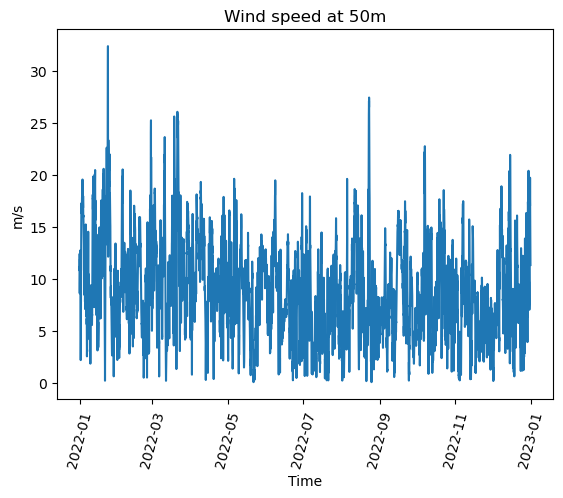

In [13]:
plt.plot(nice_time, ws)
plt.title("Wind speed at 50m")
plt.ylabel("m/s")
plt.xlabel("Time")

plt.tick_params(axis='x', labelcolor='black', labelrotation=75, labelsize=10)
plt.show()

# Histogram
This is an example on how to make a histogram from the wind speeds

Text(0.5, 1.0, 'Weibull distribution of wind speed (50m) at SN76956')

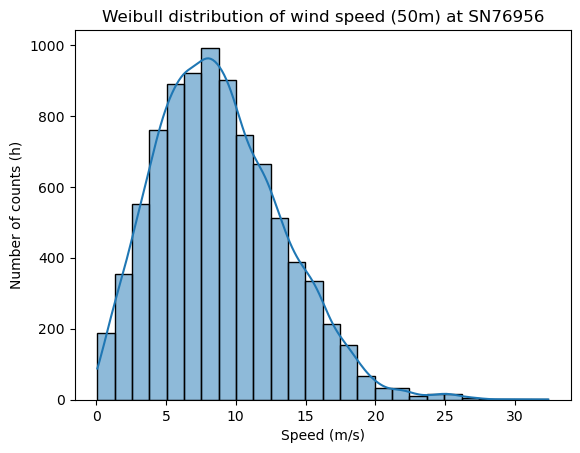

In [14]:
#install the seaborn package (if not already installed) by removing the "#" and running the code below 
#!pip3 install seaborn

import seaborn as sns

sns.histplot(data = ncfile, x = ws, kde = True, bins = 26)
plt.xlabel("Speed (m/s)")
plt.ylabel("Number of counts (h)")
plt.title(f"Weibull distribution of wind speed (50m) at {station_id}")


# Windrose
the following example show how to make a windrose at the chosen site and timespan. The windrose illustrates the distribution of wind speed and direction together. The direction in degrees is transformed into cardinal directions, 360 - N, 180 - S, 90 - E, 270 - W  

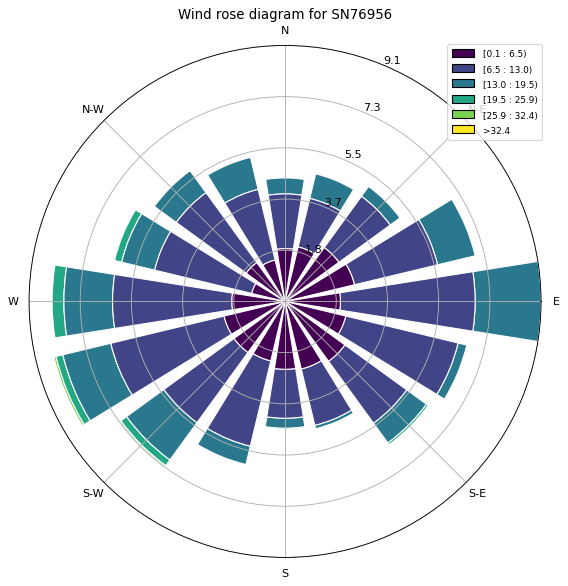

In [15]:
# run the code below if not already installed the windrose package 
#!pip3 install windrose

from windrose import WindroseAxes

speed = ncfile.variables["wind_speed"][:]
direction = ncfile.variables["wind_direction"][:] 

ax = WindroseAxes.from_ax()
ax.bar(direction,
       speed,
       normed=True, #get % of number of hours
       opening= 0.8, #width of bars
       edgecolor='white')
ax.set_legend(loc = "best")
plt.title(f"Wind rose diagram for {station_id}")
plt.show()
